In [1]:
import numpy as np
import pandas as pd
import module
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

# --- Download data -----
tickers = ['^GSPC']
start_date = '2024-07-01'
end_date = '2025-07-01'
df_prices, _ = module.download_stock_price_data(tickers, start_date, end_date)

# --- Prepare dataframe ---
df_prices = df_prices.rename(columns={"^GSPC": "Close"})  #Rename



[*********************100%***********************]  1 of 1 completed


In [2]:
# --- Compute daily log returns ---
df_prices["LogReturn"] = np.log(df_prices["Close"] / df_prices["Close"].shift(1))
df_prices.dropna(inplace=True)



In [3]:
###=========== Volatility of S&P 500 for one year========
# --- Compute annualized mean return and volatility ---
mean_return_annual = df_prices["LogReturn"].mean() * 252
volatility_annual = df_prices["LogReturn"].std() * np.sqrt(252)

# --- Output ---
print(f"Annualized mean return: {mean_return_annual:.4f}")
print(f"Annualized volatility: {volatility_annual:.4f}")

Annualized mean return: 0.1266
Annualized volatility: 0.1986


In [4]:
# --- Parameters ---
initial_price = 10000
mu = 0.1266
sigma = 0.1986
r = 0.022752  # risk-free rate
T = 1  # in years
n_steps = 252
dt = T / n_steps
n_paths = 10000

# --- Simulate GBM paths ---
np.random.seed(42)
Z = np.random.standard_normal((n_paths, n_steps))
paths = np.zeros_like(Z)
paths[:, 0] = initial_price

for t in range(1, n_steps):
    paths[:, t] = paths[:, t - 1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z[:, t - 1])

# --- Compute discounted final values and returns ---
final_values = paths[:, -1]
discounted_values = final_values * np.exp(-r * T)
returns = discounted_values / initial_price - 1

# --- Performance and risk measures ---
mean_return = np.mean(returns)
std_dev = np.std(returns)
value_at_risk_95 = np.percentile(returns, 5)
value_at_risk_99 = np.percentile(returns, 1)
expected_shortfall_95 = returns[returns <= value_at_risk_95].mean()
expected_shortfall_99 = returns[returns <= value_at_risk_99].mean()
sharpe_ratio = mean_return / std_dev


###================ Results ===============

print(f"Mean return: {mean_return:.4f}")
print(f"Standard deviation: {std_dev:.4f}")
print(f"Value at Risk (95%): {value_at_risk_95:.4f}")
print(f"Expected Shortfall (95%): {expected_shortfall_95:.4f}")
print(f"Value at Risk (99%): {value_at_risk_99:.4f}")
print(f"Expected Shortfall (99%): {expected_shortfall_99:.4f}")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")


Mean return: 0.1067
Standard deviation: 0.2190
Value at Risk (95%): -0.2189
Expected Shortfall (95%): -0.2786
Value at Risk (99%): -0.3166
Expected Shortfall (99%): -0.3582
Sharpe Ratio: 0.4873


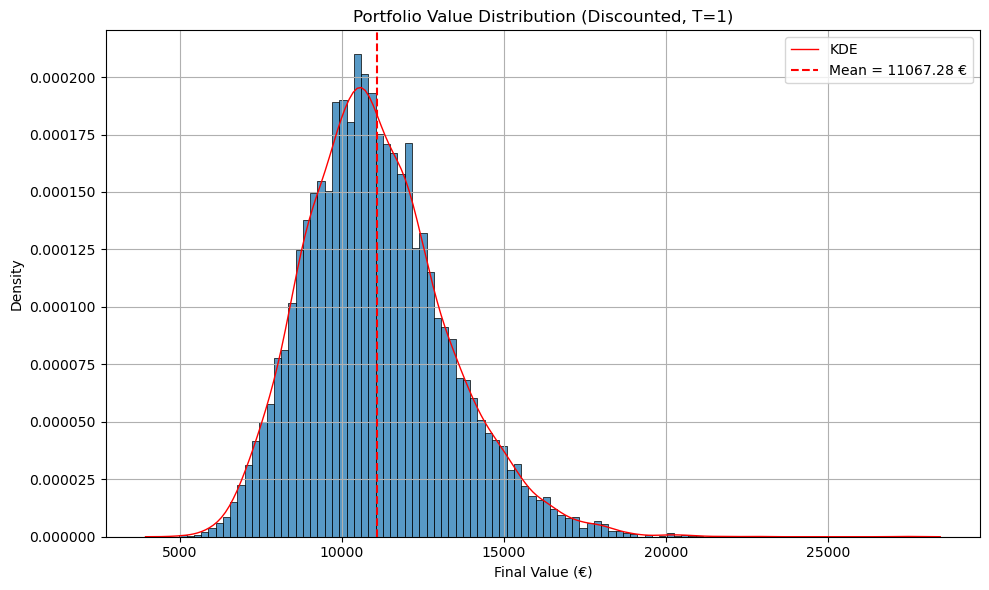

In [5]:
# Plot distribution of discounted portfolio values
plt.figure(figsize=(10, 6))
sns.histplot(discounted_values, bins=100, stat='density', edgecolor='black', color='#1f77b4')
sns.kdeplot(discounted_values, color='red', linewidth=1, label='KDE')
plt.axvline(np.mean(discounted_values), color='red', linestyle='--', label=f"Mean = {np.mean(discounted_values):.2f} €")

plt.title("Portfolio Value Distribution (Discounted, T=1)")
plt.xlabel("Final Value (€)")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
# --- Final Layout ---
plt.tight_layout()
#plt.savefig("unhedged.pdf", format='pdf', dpi=300, bbox_inches='tight')
plt.show()

In [6]:
percentiles = np.percentile(returns, [1, 5, 25, 50, 75, 95, 99])
print(f"Percentiles (Return):\n1%={percentiles[0]:.4f}, 5%={percentiles[1]:.4f}, Median={percentiles[3]:.4f}, 95%={percentiles[5]:.4f}, 99%={percentiles[6]:.4f}")
prob_loss = np.mean(returns < 0)
print(f"Probability of capital loss: {prob_loss:.2%}")

Percentiles (Return):
1%=-0.3166, 5%=-0.2189, Median=0.0862, 95%=0.4990, 99%=0.7113
Probability of capital loss: 33.09%
